![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/16.Adverse_Drug_Event_ADE_NER_and_Classifier.ipynb)

# Adverse Drug Event (ADE) Pretrained NER and Classifier Models

`ADE NER`: Extracts ADE and DRUG entities from clinical texts.


`ADE Classifier`: Classify if a sentence is ADE-related (`True`) or not (`False`)


`ADE Relation Extraction`: Classify if an adverse event is caused by a drug or not.  `1 `: Shows the adverse event and drug entities are related, `0` : Shows the adverse event and drug entities are not related


We use several datasets to train these models:

- Twitter dataset, which is used in paper "`Deep learning for pharmacovigilance: recurrent neural network architectures for labeling adverse drug reactions in Twitter posts`" (https://pubmed.ncbi.nlm.nih.gov/28339747/)
- ADE-Corpus-V2, which is used in paper "`An Attentive Sequence Model for Adverse Drug Event Extraction from Biomedical Text`" (https://arxiv.org/abs/1801.00625) and available online: https://huggingface.co/datasets/ade_corpus_v2/tree/main.
- CADEC dataset, which is used in paper `Cadec: A corpus of adverse drug event annotations` (https://pubmed.ncbi.nlm.nih.gov/25817970)

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.0 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [3]:
import os
import json


import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline,PipelineModel

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'], params=params)

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 5.3.2
Spark NLP_JSL Version : 5.3.3


## Healthcare NLP for Data Scientists Course

If you are not familiar with the components in this notebook, you can check [Healthcare NLP for Data Scientists Udemy Course](https://www.udemy.com/course/healthcare-nlp-for-data-scientists/) and the [MOOC Notebooks](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/Spark_NLP_Udemy_MOOC/Healthcare_NLP) for each components.

## ADE Classifier

ADE Classifier Classifies if a sentence is ADE-related (`True`) or not (`False`)

`True` : The sentence is talking about a possible ADE

`False` : The sentences doesn't have any information about an ADE.


|index |model |Predicted Entities|
|-----:|:-----|:----------------:|
| 1| [classifierdl_ade_biobert](https://nlp.johnsnowlabs.com/2021/01/21/classifierdl_ade_biobert_en.html)   |True, False|
| 2| [classifierdl_ade_clinicalbert](https://nlp.johnsnowlabs.com/2021/01/21/classifierdl_ade_clinicalbert_en.html)  |True, False|
| 3| [classifierdl_ade_conversational_biobert](https://nlp.johnsnowlabs.com/2021/01/21/classifierdl_ade_conversational_biobert_en.html)  |True, False|
| 4| [bert_sequence_classifier_ade](https://nlp.johnsnowlabs.com/2022/02/08/bert_sequence_classifier_ade_en.html)  |True, False|
| 5| [bert_sequence_classifier_ade_augmented](https://nlp.johnsnowlabs.com/2022/07/27/bert_sequence_classifier_ade_augmented_en_3_0.html)   |ADE, noADE|
| 6| [distilbert_sequence_classifier_ade](https://nlp.johnsnowlabs.com/2022/02/08/distilbert_sequence_classifier_ade_en.html)  |True, False|



### ADE Classifier with BioBert

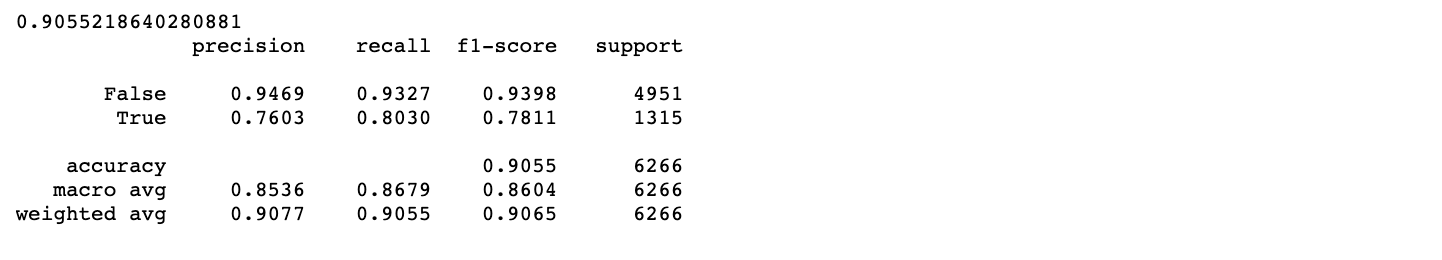

In [4]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

bert_embeddings = BertEmbeddings.pretrained("biobert_pubmed_base_cased")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")\
    .setMaxSentenceLength(512)

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["sentence", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")\
    .setStorageRef('biobert_pubmed_base_cased')

classsifierdl = ClassifierDLModel.pretrained("classifierdl_ade_biobert", "en", "clinical/models")\
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("class")

ade_clf_pipeline = Pipeline(
    stages=[
        documentAssembler,
        tokenizer,
        bert_embeddings,
        embeddingsSentence,
        classsifierdl
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_clf_model = ade_clf_pipeline.fit(empty_data)

ade_lp_pipeline = LightPipeline(ade_clf_model)

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
classifierdl_ade_biobert download started this may take some time.
Approximate size to download 21.8 MB
[OK!]


In [5]:
text = """I have an allergic reaction to vancomycin so I have itchy skin, sore throat/burning/itching, numbness of tongue and gums.
I would not recommend this drug to anyone, especially since I have never had such an adverse reaction to any other medication."""

print(ade_lp_pipeline.fullAnnotate(text)[0]["class"][0].result)
print(ade_lp_pipeline.fullAnnotate(text)[0]["class"])

True
[Annotation(category, 0, 247, True, {'sentence': '0', 'False': '0.012636117', 'True': '0.9873639'}, [])]


In [6]:
text="I just took an Advil and have no gastric problems so far."

print(ade_lp_pipeline.fullAnnotate(text)[0]["class"][0].result)
print(ade_lp_pipeline.fullAnnotate(text)[0]["class"])

False
[Annotation(category, 0, 56, False, {'sentence': '0', 'False': '0.9999769', 'True': '2.3126835E-5'}, [])]


As you can see `gastric problems` is not detected as `ADE` as it is in a negative context. So, classifier did a good job detecting that.

In [7]:
text="""Always tired, and possible blood clots. I was on Voltaren for about 4 years and all of the sudden had a minor stroke and had blood clots that traveled to my eye.
I had every test in the book done at the hospital, and they couldn't find anything. I was completley healthy! I am thinking it was from the voltaren.
I have been off of the drug for 8 months now, and have never felt better. I started eating healthy and working out and that has help alot.
I can now sleep all thru the night. I wont take this again. If I have the back pain, I will pop a tylonol instead."""

print(ade_lp_pipeline.fullAnnotate(text)[0]["class"][0].result)
print(ade_lp_pipeline.fullAnnotate(text)[0]["class"])

True
[Annotation(category, 0, 564, True, {'sentence': '0', 'False': '0.0146723185', 'True': '0.9853277'}, [])]


In [8]:
ade_lp_pipeline.fullAnnotate(text)[0]["class"][0].metadata["True"]

'0.9853277'

In [9]:
texts = ["The patient was prescribed 1000 mg fish oil and multivitamins. She was discharged on zopiclone and ambrisentan.",
"I feel a bit drowsy & have a little blurred vision, after taking a pill.",
"I've been on Arthrotec 50 for over 10 years on and off, only taking it when I needed it.",
"Due to my arthritis getting progressively worse, to the point where I am in tears with the agony, gp's started me on 75 twice a day and I have to take it every day for the next month to see how I get on, here goes.",
"So far its been very good, no pains remain, but I feel a bit weird, didn't have that when on 50."]

for text in texts:

  result = ade_lp_pipeline.annotate(text)
  cls = ade_lp_pipeline.fullAnnotate(text)[0]["class"][0].result
  confidence = ade_lp_pipeline.fullAnnotate(text)[0]["class"][0].metadata[cls]
  print (cls,"\t",confidence)


False 	 0.9999689
True 	 0.7971174
False 	 0.99999654
True 	 0.50409865
False 	 0.93385196


### ADE Classifier trained with conversational (short) sentences

This model is trained on short, conversational sentences related to ADE and is supposed to do better on the text that is short and used in a daily context.

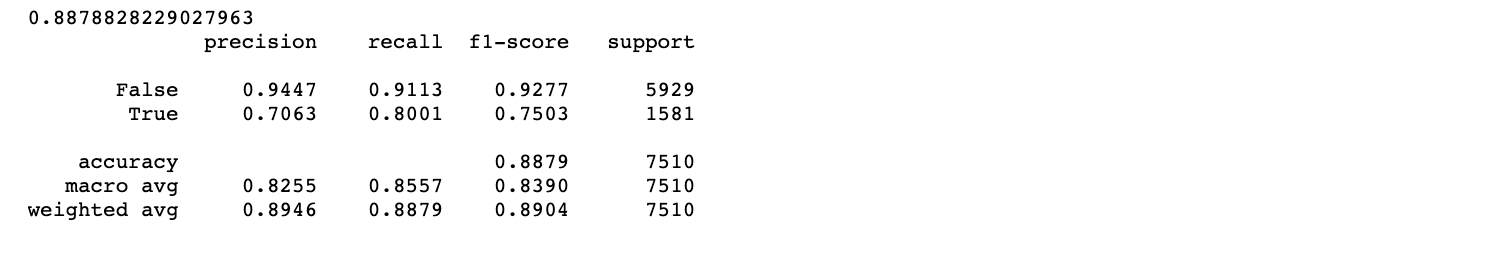

In [10]:
conv_classsifierdl = ClassifierDLModel.pretrained("classifierdl_ade_conversational_biobert", "en", "clinical/models")\
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("class")

conv_ade_clf_pipeline = Pipeline(
    stages=[
        documentAssembler,
        tokenizer,
        bert_embeddings,
        embeddingsSentence,
        conv_classsifierdl
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

conv_ade_clf_model = conv_ade_clf_pipeline.fit(empty_data)

conv_ade_lp_pipeline = LightPipeline(conv_ade_clf_model)

classifierdl_ade_conversational_biobert download started this may take some time.
Approximate size to download 21.8 MB
[OK!]


In [11]:
text = "after taking a pill, he denies any pain"

conv_ade_lp_pipeline.annotate(text)['class'][0]

print(conv_ade_lp_pipeline.fullAnnotate(text)[0]["class"][0].result)
print(conv_ade_lp_pipeline.fullAnnotate(text)[0]["class"])

False
[Annotation(category, 0, 38, False, {'sentence': '0', 'False': '0.9569519', 'True': '0.04304803'}, [])]


### ADE Sequence Classifier

MedicalBertForSequenceClassification

In [12]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

sequenceClassifier = MedicalBertForSequenceClassification.pretrained("bert_sequence_classifier_ade_augmented", "en", "clinical/models")\
    .setInputCols(["document","token"])\
    .setOutputCol("class")


ade_clf_pipeline = Pipeline(
    stages=[
        document_assembler,
        tokenizer,
        sequenceClassifier
])


data = spark.createDataFrame([["So glad I am off effexor, so sad it ruined my teeth. tip Please be carefull taking antideppresiva and read about it 1st"],
                              ["Religare Capital Ranbaxy has been accepting approval for Diovan since 2012"]]).toDF("text")

result = ade_clf_pipeline.fit(data).transform(data)

result.select("text", "class.result").show(truncate=False)

bert_sequence_classifier_ade_augmented download started this may take some time.
[OK!]
+-----------------------------------------------------------------------------------------------------------------------+-------+
|text                                                                                                                   |result |
+-----------------------------------------------------------------------------------------------------------------------+-------+
|So glad I am off effexor, so sad it ruined my teeth. tip Please be carefull taking antideppresiva and read about it 1st|[ADE]  |
|Religare Capital Ranbaxy has been accepting approval for Diovan since 2012                                             |[noADE]|
+-----------------------------------------------------------------------------------------------------------------------+-------+



MedicalDistilBertForSequenceClassification

In [13]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")


sequenceClassifier = MedicalDistilBertForSequenceClassification.pretrained("distilbert_sequence_classifier_ade", "en", "clinical/models")\
    .setInputCols(["document","token"])\
    .setOutputCol("class")

ade_clf_pipeline = Pipeline(stages=[
                    document_assembler,
                    tokenizer,
                    sequenceClassifier])


data = spark.createDataFrame([["I have an allergic reaction to vancomycin so I have itchy skin, sore throat/burning/itching, numbness of tongue and gums.I would not recommend this drug to anyone, especially since I have never had such an adverse reaction to any other medication."],
                              ["Religare Capital Ranbaxy has been accepting approval for Diovan since 2012"]]).toDF("text")

result = ade_clf_pipeline.fit(data).transform(data)

result.select("text", "class.result").show(truncate=100)

distilbert_sequence_classifier_ade download started this may take some time.
[OK!]
+----------------------------------------------------------------------------------------------------+-------+
|                                                                                                text| result|
+----------------------------------------------------------------------------------------------------+-------+
|I have an allergic reaction to vancomycin so I have itchy skin, sore throat/burning/itching, numb...| [True]|
|                          Religare Capital Ranbaxy has been accepting approval for Diovan since 2012|[False]|
+----------------------------------------------------------------------------------------------------+-------+



## ADE NER

Extracts `ADE` and `DRUG` entities from text.

|    | model_name                 |Predicted Entities|
|---:|:---------------------------|:----------------:|
|  1 | [ner_ade_clinical](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_clinical_en.html)      |ADE, DRUG|
|  2 | [ner_ade_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_biobert_en.html)        |ADE, DRUG|
|  3 | [ner_ade_healthcare](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_healthcare_en.html)  |ADE, DRUG|
|  4 | [ner_ade_clinicalbert](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_clinicalbert_en.html)   |ADE, DRUG|
|  5 | [bert_token_classifier_ner_ade](https://nlp.johnsnowlabs.com/2022/01/04/bert_token_classifier_ner_ade_en.html) |ADE, DRUG|
|  6 | [bert_token_classifier_ade_tweet_binary](https://nlp.johnsnowlabs.com/2022/07/29/bert_token_classifier_ade_tweet_binary_en_3_0.html) |ADE |




#### ADE NER with Word embeddings

ner_ade_clinical benchmark

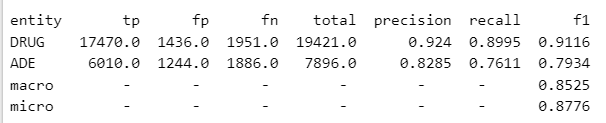

In [14]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

ade_ner = MedicalNerModel.pretrained("ner_ade_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

ner_pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ade_ner,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_model = ner_pipeline.fit(empty_data)

ade_ner_lp = LightPipeline(ade_ner_model)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_ade_clinical download started this may take some time.
[OK!]


In [15]:
text = """I have an allergic reaction to vancomycin so I have itchy skin, sore throat/burning/itching, numbness of tongue and gums.
I would not recommend this drug to anyone, especially since I have never had such an adverse reaction to any other medication."""

light_result = ade_ner_lp.fullAnnotate(text)

chunks = []
entities = []
begin =[]
end = []
confidence = []

for n in light_result[0]['ner_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    confidence.append(n.metadata['confidence'])

import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                    'begin': begin, 'end': end, "confidence":confidence})

df

,chunks,entities,begin,end,confidence
0,allergic reaction,ADE,10,26,0.68645
1,vancomycin,DRUG,31,40,0.9988
2,itchy skin,ADE,52,61,0.71365
3,sore throat/burning/itching,ADE,64,90,0.81229997
4,numbness of tongue,ADE,93,110,0.6829667
5,gums,ADE,116,119,0.7055


In [16]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk')

#### ADE NER with Bert embeddings

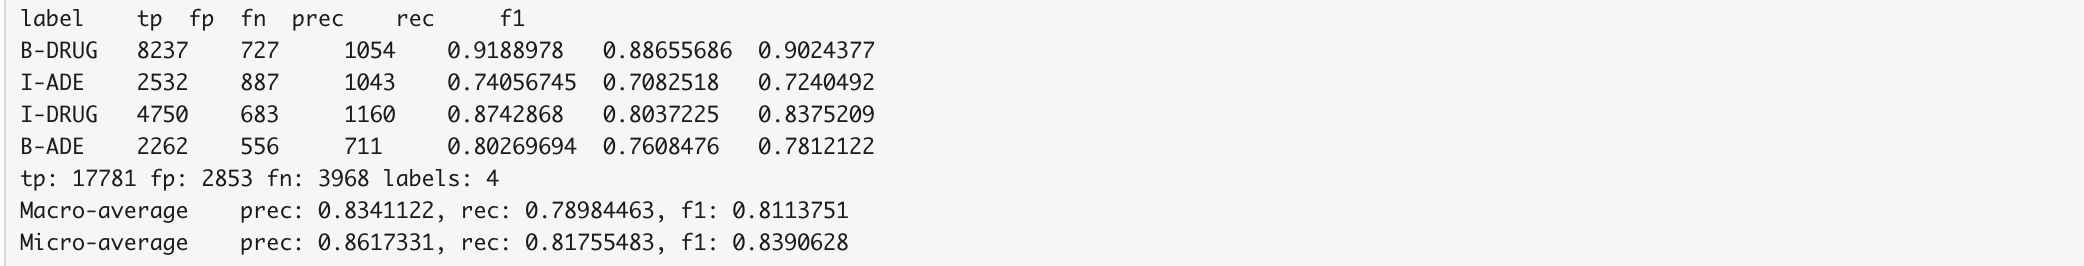

In [17]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

bert_embeddings = BertEmbeddings.pretrained("biobert_pubmed_base_cased")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

ade_ner_bert = MedicalNerModel.pretrained("ner_ade_biobert", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

ner_pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    bert_embeddings,
    ade_ner_bert,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_model_bert = ner_pipeline.fit(empty_data)

ade_ner_lp_bert = LightPipeline(ade_ner_model_bert)

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
ner_ade_biobert download started this may take some time.
[OK!]


In [18]:
text = """I have an allergic reaction to vancomycin so I have itchy skin, sore throat/burning/itching, numbness of tongue and gums.
I would not recommend this drug to anyone, especially since I have never had such an adverse reaction to any other medication."""

light_result = ade_ner_lp_bert.fullAnnotate(text)

chunks = []
entities = []
begin =[]
end = []
confidence = []

for n in light_result[0]['ner_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    confidence.append(n.metadata['confidence'])

import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                    'begin': begin, 'end': end, "confidence":confidence})

df

,chunks,entities,begin,end,confidence
0,allergic reaction,ADE,10,26,0.8071
1,vancomycin,DRUG,31,40,0.9979
2,itchy skin,ADE,52,61,0.94315004
3,sore throat/burning/itching,ADE,64,90,0.90735
4,numbness of tongue and gums,ADE,93,119,0.90212
5,any other medication,DRUG,227,246,0.75869995


In [19]:
visualiser.display(light_result[0], label_col='ner_chunk')

#### ADE NER for Tweets

In [20]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

tokenClassifier = MedicalBertForTokenClassifier.pretrained("bert_token_classifier_ade_tweet_binary", "en", "clinical/models")\
    .setInputCols("token", "sentence")\
    .setOutputCol("ner")\
    .setCaseSensitive(True)

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")


nlpPipeline =  Pipeline(stages=[
                      documentAssembler,
                      sentenceDetector,
                      tokenizer,
                      tokenClassifier,
                      ner_converter])

ade_ner_model_tweet= nlpPipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

ade_ner_lp_tweet = LightPipeline(ade_ner_model_tweet)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
bert_token_classifier_ade_tweet_binary download started this may take some time.
[OK!]


In [21]:
twitter_text = """I understand you very well. :( just got 1st urgh ! Humira drug worked for me for just 3 months then got painful reactions.
This Vyvanse got me sweating right now and i dont even know why!,
Wonder which drug is doing this memory lapse thing. My guess the Duloxetine.
I used to be on paxil but that made me more depressed and prozac made me angry.
Maybe it's because of the effect of seroquel, but when I eat fast carbohydrates, I feel the sugar drop."""


In [22]:
light_result = ade_ner_lp_tweet.fullAnnotate(twitter_text)

chunks = []
entities = []
begin =[]
end = []
confidence = []

for n in light_result[0]['ner_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    confidence.append(n.metadata['confidence'])

import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                    'begin': begin, 'end': end, "confidence":confidence})

df

,chunks,entities,begin,end,confidence
0,painful reactions,ADE,104,120,0.99102944
1,sweating,ADE,143,150,0.9993362
2,memory lapse,ADE,221,232,0.98930156
3,depressed,ADE,310,318,0.99975455
4,angry,ADE,339,343,0.99960786
5,sugar drop,ADE,438,447,0.9028448


In [23]:
visualiser.display(light_result[0], label_col='ner_chunk')

## ADE NER with AssertionDL Model

In [24]:
assertion_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ass_ner_chunk")\
    .setWhiteList(['ADE'])

biobert_assertion = AssertionDLModel.pretrained("assertion_dl_biobert", "en", "clinical/models") \
    .setInputCols(["sentence", "ass_ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")

assertion_ner_pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    bert_embeddings,
    ade_ner_bert,
    ner_converter,
    assertion_ner_converter,
    biobert_assertion])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ass_ner_model_bert = assertion_ner_pipeline.fit(empty_data)

ade_ass_ner_model_lp_bert = LightPipeline(ade_ass_ner_model_bert)

assertion_dl_biobert download started this may take some time.
[OK!]


In [25]:
import pandas as pd
text = """I feel a bit drowsy & have a little blurred vision, so far no gastric problems.
  I have been on Arthrotec 50 for over 10 years on and off, only taking it when I needed it.
  Due to my arthritis getting progressively worse, to the point where I am in tears with the agony,
  gp's started me on 75 twice a day and I have to take it every day for the next month to see how I get on, here goes.
  So far its been very good, no pains remain, but I feel a bit weird, didn't have that when on 50."""

print (text)

light_result = ade_ass_ner_model_lp_bert.fullAnnotate(text)[0]

chunks=[]
entities=[]
status=[]
confidence=[]


for n,m in zip(light_result['ass_ner_chunk'],light_result['assertion']):

    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    status.append(m.result)
    confidence.append(n.metadata['confidence'])

df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status, "confidence":confidence})

df

I feel a bit drowsy & have a little blurred vision, so far no gastric problems.
  I have been on Arthrotec 50 for over 10 years on and off, only taking it when I needed it.
  Due to my arthritis getting progressively worse, to the point where I am in tears with the agony,
  gp's started me on 75 twice a day and I have to take it every day for the next month to see how I get on, here goes.
  So far its been very good, no pains remain, but I feel a bit weird, didn't have that when on 50.


,chunks,entities,assertion,confidence
0,drowsy,ADE,present,0.7226
1,blurred vision,ADE,present,0.9296
2,gastric problems,ADE,absent,0.8494
3,pains,ADE,absent,0.9239


In [26]:
from sparknlp_display import AssertionVisualizer

vis = AssertionVisualizer()

vis.display(light_result, 'ass_ner_chunk', 'assertion')

Looks great ! `gastric problems` and `pains` are detected as `ADE` and `absent`

## ADE Relation Extraction Model

ADE Relation Extraction classifies if an adverse event is caused by a drug or not. 1: Shows the adverse event and drug entities are related, 0 : Shows the adverse event and drug entities are not related

|    | model_name                 |Predicted Entities|
|---:|:---------------------------|:----------------:|
|  1 | [re_ade_clinical](https://nlp.johnsnowlabs.com/2021/07/12/re_ade_clinical_en.html)    |0, 1|
|  2 | [re_ade_biobert](https://nlp.johnsnowlabs.com/2021/07/16/re_ade_biobert_en.html)      |0, 1|
|  3 | [redl_ade_biobert](https://nlp.johnsnowlabs.com/2021/07/12/redl_ade_biobert_en.html)  |0, 1|
|  4 | [re_ade_conversational](https://nlp.johnsnowlabs.com/2022/07/27/re_ade_conversational_en_3_0.html)  |not_related, is_related|

In [27]:
# get relations in a pandas dataframe
import pandas as pd

def get_relations_df (results, rel_col='relations', chunk_col='ner_chunks'):
    rel_pairs=[]
    chunks = []

    for rel in results[rel_col]:
        rel_pairs.append((
            rel.metadata['entity1_begin'],
            rel.metadata['entity1_end'],
            rel.metadata['chunk1'],
            rel.metadata['entity1'],
            rel.metadata['entity2_begin'],
            rel.metadata['entity2_end'],
            rel.metadata['chunk2'],
            rel.metadata['entity2'],
            rel.result,
            rel.metadata['confidence'],
        ))

    for chunk in results[chunk_col]:
        chunks.append((
            chunk.metadata["sentence"],
            chunk.begin,
            chunk.end,
            chunk.result,
        ))

    rel_df = pd.DataFrame(rel_pairs, columns=['entity1_begin', 'entity1_end', 'chunk1', 'entity1', 'entity2_begin', 'entity2_end', 'chunk2', 'entity2', 'relation', 'confidence'])

    chunks_df = pd.DataFrame(chunks, columns = ["sentence", "begin", "end", "chunk"])
    chunks_df.begin = chunks_df.begin.astype(str)
    chunks_df.end = chunks_df.end.astype(str)

    result_df = pd.merge(rel_df,chunks_df, left_on=["entity1_begin", "entity1_end", "chunk1"], right_on=["begin", "end", "chunk"])[["sentence"] + list(rel_df.columns)]


    return result_df

In [28]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

words_embedder = WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

ner_tagger = MedicalNerModel()\
    .pretrained("ner_ade_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token", "embeddings")\
    .setOutputCol("ner_tags")

ner_chunker = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

reModel = RelationExtractionModel()\
    .pretrained("re_ade_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(20)\
    .setRelationPairs(["drug-ade, ade-drug"])\
    .setRelationPairsCaseSensitive(False)\
    .setCustomLabels({"1": "is_related", "0": "not_related"})

pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    words_embedder,
    pos_tagger,
    ner_tagger,
    ner_chunker,
    dependency_parser,
    reModel
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
ade_model = pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
ner_ade_clinical download started this may take some time.
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
re_ade_clinical download started this may take some time.
[OK!]


In [29]:
text = ["""
Hypersensitivity to aspirin can be manifested as acute asthma, urticaria and/or angioedema, or a systemic anaphylactoid reaction.
A patient had undergone a renal transplantation as a result of malignant hypertension, and immunosuppressive therapy consisting of cyclosporin and prednisone ,  developed  sweating  and  thrombosis alone 5 years following the transplantation but there were not stomach pain.
A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for   rheumatoid arthritis  presented  with  tense bullae and cutaneous fragility on the face and the back of the hands.""",

"""We describe the side effects of 5-FU in a colon cancer patient who suffered severe mucositis,  prolonged myelosuppression, and neurologic toxicity that required admission to the intensive care unit who  has a healthy appetite.
The reported cases of in utero exposure to cyclosposphamide shared the following manifestations with our patient who suffered  growth deficiency, developmental delay, craniosynostosis, blepharophimosis, flat nasal bridge and abnormal ears.
I have an allergic reaction to vancomycin so I have itchy skin, sore throat/burning/itching, numbness of tongue and gums.I would not recommend this drug to anyone, especially since I have never had such an adverse reaction to any other medication.
I experienced fatigue, muscle cramps, anxiety, agression and sadness after taking Lipitor but no more adverse after passing Zocor.
A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands.""" ]

In [30]:
light_results = LightPipeline(ade_model).fullAnnotate(text)

In [31]:
get_relations_df(light_results[0], 'relations')

,sentence,entity1_begin,entity1_end,chunk1,entity1,entity2_begin,entity2_end,chunk2,entity2,relation,confidence
0,0,21,27,aspirin,DRUG,50,61,acute asthma,ADE,is_related,1.0
1,0,21,27,aspirin,DRUG,64,72,urticaria,ADE,is_related,1.0
2,0,21,27,aspirin,DRUG,81,90,angioedema,ADE,is_related,1.0
3,0,21,27,aspirin,DRUG,98,128,systemic anaphylactoid reaction,ADE,is_related,0.99994946
4,1,262,272,cyclosporin,DRUG,303,310,sweating,ADE,is_related,0.99999833
5,1,262,272,cyclosporin,DRUG,318,327,thrombosis,ADE,is_related,1.0
6,1,278,287,prednisone,DRUG,303,310,sweating,ADE,is_related,1.0
7,1,278,287,prednisone,DRUG,318,327,thrombosis,ADE,is_related,1.0
8,2,431,438,naproxen,DRUG,548,559,tense bullae,ADE,is_related,1.0
9,2,431,438,naproxen,DRUG,565,621,cutaneous fragility on the face and the back o...,ADE,is_related,0.999218


In [32]:
from sparknlp_display import RelationExtractionVisualizer

vis = RelationExtractionVisualizer()
vis.display(light_results[0], 'relations', show_relations=True) # default show_relations: True

## ADE models applied to Spark Dataframes

In [33]:
import pyspark.sql.functions as F

! wget -q	https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/sample_ADE_dataset.csv

ade_DF = spark.read\
                .option("header", "true")\
                .csv("./sample_ADE_dataset.csv")\
                .filter(F.col("label").isin(['True','False']))

ade_DF.show(truncate=50)

+--------------------------------------------------+-----+
|                                              text|label|
+--------------------------------------------------+-----+
|Do U know what Meds are R for bipolar depressio...|False|
|# hypercholesterol: Because of elevated CKs (pe...| True|
|Her weight, respirtory status and I/O should be...|False|
|* DM - Pt had several episodes of hypoglycemia ...| True|
|We report the case of a female acromegalic pati...| True|
|2 . Calcipotriene 0.005% Cream Sig: One (1) App...|False|
|Always tired, and possible blood clots. I was o...| True|
|A difference in chemical structure between thes...|False|
|10 . She was left on prednisone 20mg qd due to ...|False|
|The authors suggest that risperidone may increa...| True|
|- Per oral maxillofacial surgery there is no ev...|False|
|@marionjross Cipro is just as bad! Stay away fr...|False|
|A young woman with epilepsy had tonic-clonic se...| True|
|Intravenous methotrexate is an effective adjunc...|Fals

**With BioBert version of NER** (will be slower but more accurate)

In [34]:
import pyspark.sql.functions as F

ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['ADE'])

ner_pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    bert_embeddings,
    ade_ner_bert,
    ner_converter])


empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_model = ner_pipeline.fit(empty_data)

result = ade_ner_model.transform(ade_DF)

sample_df = result.select('text','ner_chunk.result')\
                  .toDF('text','ADE_phrases').filter(F.size('ADE_phrases')>0).toPandas()

In [35]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)

In [36]:
sample_df.sample(20)

,text,ADE_phrases
4,"The authors suggest that risperidone may increase affect in patients with schizophrenia and that some patients, especially those with anxiety, may have difficulty managing the increase.",[increase affect]
27,Succinylcholine-induced hyperkalemia in a patient with mucositis secondary to chemotherapy.,[hyperkalemia]
23,The authors report a case of mania occurring in a woman in late life who had begun receiving hormone replacement therapy for osteoporosis.,[mania]
2,We report the case of a female acromegalic patient in whom multiple hepatic adenomas appeared soon after danazol treatment for uterine fibromatosis.,[hepatic adenomas]
21,"2 years with no problems, then toe neuropathy for two years now and other foot problems because of this I assume. I stopped Lipitor after taking it for 2 years and toe neuropathy started. I also had stomach problems and pain. After stopping Lipitor, I thought my heart would jump out of my chest, but now stomach and heart are both OK - Feet are terrible thanks to Lipitor. I know many others that have had problems with Lipitor - feet and legs - and had to stop. All my blood test were normal. I weigh 114 and 5'2 . Hike, play golf and keep busy. It is a terrible drug and should be off the market.","[toe neuropathy, foot problems, toe neuropathy, stomach problems, pain]"
29,Treatment of anticholinergic-induced ileus with neostigmine.,[ileus]
5,A young woman with epilepsy had tonic-clonic seizures during antineoplastic therapy with adriamycin and cisplatin.,[tonic-clonic seizures]
9,# thrombocytopenia: Secondary to chemotherapy and MDS/AML concerns.,[thrombocytopenia]
11,"# Maculopapular rash: over extremities, chest and back, thought [**1-14**] zosyn which has been discontinued, mother with [**Name2 (NI) *] allergy, consider [**Name2 (NI) *] an allergy.",[Maculopapular rash]
24,Fatal hypoglycemia after cytotoxic chemotherapy: a report of two cases and a review of the literature.,[Fatal hypoglycemia]


**Doing the same with clinical embeddings version** (faster results)

In [37]:
import pyspark.sql.functions as F

ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['ADE'])

ner_pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ade_ner,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_model = ner_pipeline.fit(empty_data)

result = ade_ner_model.transform(ade_DF)

result.select('text','ner_chunk.result')\
.toDF('text','ADE_phrases').filter(F.size('ADE_phrases')>0)\
.show(truncate=70)


+----------------------------------------------------------------------+----------------------------------------------------------------------+
|                                                                  text|                                                           ADE_phrases|
+----------------------------------------------------------------------+----------------------------------------------------------------------+
|# hypercholesterol: Because of elevated CKs (peaked at 819) the pat...|                                                        [elevated CKs]|
|We report the case of a female acromegalic patient in whom multiple...|                                           [multiple hepatic adenomas]|
|Always tired, and possible blood clots. I was on Voltaren for about...|                      [blood clots that traveled to my eye, back pain]|
|The authors suggest that risperidone may increase affect in patient...|                                                     [increase a

### Creating sentence dataframe (one sentence per row) and getting ADE entities and categories

In [38]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setExplodeSentences(True)

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

bert_embeddings = BertEmbeddings.pretrained("biobert_pubmed_base_cased")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["sentence", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")\
    .setStorageRef('biobert_pubmed_base_cased')

classsifierdl = ClassifierDLModel.pretrained("classifierdl_ade_biobert", "en", "clinical/models")\
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("class")\
    .setStorageRef('biobert_pubmed_base_cased')

ade_ner = MedicalNerModel.pretrained("ner_ade_biobert", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['ADE'])

ner_clf_pipeline = Pipeline(
    stages=[documentAssembler,
            sentenceDetector,
            tokenizer,
            bert_embeddings,
            embeddingsSentence,
            classsifierdl,
            ade_ner,
            ner_converter])

ade_Sentences = ner_clf_pipeline.fit(ade_DF)

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
classifierdl_ade_biobert download started this may take some time.
Approximate size to download 21.8 MB
[OK!]
ner_ade_biobert download started this may take some time.
[OK!]


In [39]:
import pyspark.sql.functions as F

ade_Sentences.transform(ade_DF).select('sentence.result','ner_chunk.result','class.result')\
            .toDF('sentence','ADE_phrases','is_ADE').show(truncate=60)

+------------------------------------------------------------+---------------------------------------------+-------+
|                                                    sentence|                                  ADE_phrases| is_ADE|
+------------------------------------------------------------+---------------------------------------------+-------+
|         [Do U know what Meds are R for bipolar depression?]|                                           []|[False]|
|         [Currently #FDA approved #quetiapine AKA #Seroquel]|                                           []|[False]|
|[# hypercholesterol: Because of elevated CKs (peaked at 8...|                               [elevated CKs]|[False]|
|[Her weight, respirtory status and I/O should be monitore...|                                           []|[False]|
|[* DM - Pt had several episodes of hypoglycemia on lantus...|                               [hypoglycemia]| [True]|
|[We report the case of a female acromegalic patient in wh...|  

## Creating a pretrained pipeline with ADE NER, Assertion and Classifer

In [40]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

bert_embeddings = BertEmbeddings.pretrained("biobert_pubmed_base_cased")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

ade_ner = MedicalNerModel.pretrained("ner_ade_biobert", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")\
    .setStorageRef('biobert_pubmed_base_cased')

ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

assertion_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ass_ner_chunk")\
    .setWhiteList(['ADE'])

biobert_assertion = AssertionDLModel.pretrained("assertion_dl_biobert", "en", "clinical/models") \
    .setInputCols(["sentence", "ass_ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["sentence", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")\
    .setStorageRef('biobert_pubmed_base_cased')

classsifierdl = ClassifierDLModel.pretrained("classifierdl_ade_conversational_biobert", "en", "clinical/models")\
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("class")

ade_clf_pipeline = Pipeline(
    stages=[documentAssembler,
            tokenizer,
            bert_embeddings,
            ade_ner,
            ner_converter,
            assertion_ner_converter,
            biobert_assertion,
            embeddingsSentence,
            classsifierdl])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_clf_model = ade_clf_pipeline.fit(empty_data)

ade_ner_clf_pipeline = LightPipeline(ade_ner_clf_model)

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
ner_ade_biobert download started this may take some time.
[OK!]
assertion_dl_biobert download started this may take some time.
[OK!]
classifierdl_ade_conversational_biobert download started this may take some time.
Approximate size to download 21.8 MB
[OK!]


In [41]:
classsifierdl.getStorageRef()

'biobert_pubmed_base_cased'

In [42]:
text =  'I have always felt tired, but no blood clots. I was on Voltaren for about 4 years and all of the sudden had a minor stroke and had blood clots that traveled to my eye. I had every test in the book done at the hospital, and they couldnt find anything. I was completley healthy! I am thinking it was from the voltaren. I have been off of the drug for 8 months now, and have never felt better. I started eating healthy and working out and that has help alot. I can now sleep all thru the night. I wont take this again. If I have the back pain, I will pop a tylonol instead.'

light_result = ade_ner_clf_pipeline.fullAnnotate(text)

print (light_result[0]['class'][0].metadata)

chunks = []
entities = []
begin =[]
end = []
confidence = []

for n in light_result[0]['ner_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    confidence.append(n.metadata['confidence'])

import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                    'begin': begin, 'end': end, "confidence":confidence})

df

{'sentence': '0', 'False': '0.028450416', 'True': '0.97154963'}


,chunks,entities,begin,end,confidence
0,felt tired,ADE,14,23,0.86925
1,blood clots,ADE,33,43,0.93635
2,Voltaren,DRUG,55,62,0.9977
3,stroke,ADE,116,121,0.831
4,blood clots that traveled to my eye,ADE,131,165,0.8084857
5,voltaren,DRUG,307,314,0.7912


In [43]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='sentence')

In [44]:
import pandas as pd

text = 'I have always felt tired, but no blood clots. I was on Voltaren for about 4 years and all of the sudden had a minor stroke and had blood clots that traveled to my eye. I had every test in the book done at the hospital, and they couldnt find anything. I was completley healthy! I am thinking it was from the voltaren. I have been off of the drug for 8 months now, and have never felt better. I started eating healthy and working out and that has help alot. I can now sleep all thru the night. I wont take this again. If I have the back pain, I will pop a tylonol instead.'

print (text)

light_result = ade_ass_ner_model_lp_bert.fullAnnotate(text)[0]

chunks=[]
entities=[]
status=[]
confidence = []

for n,m in zip(light_result['ass_ner_chunk'],light_result['assertion']):

    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    status.append(m.result)
    confidence.append(m.metadata['confidence'])

df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status, "confidence":confidence})

df

I have always felt tired, but no blood clots. I was on Voltaren for about 4 years and all of the sudden had a minor stroke and had blood clots that traveled to my eye. I had every test in the book done at the hospital, and they couldnt find anything. I was completley healthy! I am thinking it was from the voltaren. I have been off of the drug for 8 months now, and have never felt better. I started eating healthy and working out and that has help alot. I can now sleep all thru the night. I wont take this again. If I have the back pain, I will pop a tylonol instead.


,chunks,entities,assertion,confidence
0,tired,ADE,present,0.9998
1,blood clots,ADE,absent,1.0
2,stroke,ADE,present,1.0
3,blood clots that traveled to my eye,ADE,present,1.0
4,completley healthy,ADE,present,1.0


In [45]:
from sparknlp_display import AssertionVisualizer

vis = AssertionVisualizer()

vis.display(light_result, 'ass_ner_chunk', 'assertion')

In [46]:
result = ade_ner_clf_pipeline.annotate('I just took an Advil 100 mg and it made me drowsy')

print (result['class'])
print(list(zip(result['token'],result['ner'])))

['False']
[('I', 'O'), ('just', 'O'), ('took', 'O'), ('an', 'O'), ('Advil', 'B-DRUG'), ('100', 'O'), ('mg', 'O'), ('and', 'O'), ('it', 'O'), ('made', 'O'), ('me', 'O'), ('drowsy', 'B-ADE')]


In [47]:
ade_ner_clf_model.save('ade_pretrained_pipeline')

In [48]:
from sparknlp.pretrained import PretrainedPipeline

ade_pipeline = PretrainedPipeline.from_disk('ade_pretrained_pipeline')

ade_pipeline.annotate('I just took an Advil 100 mg then it made me drowsy')

{'ner_chunk': ['Advil', 'drowsy'],
 'assertion': ['conditional'],
 'sentence_embeddings': ['I just took an Advil 100 mg then it made me drowsy'],
 'token': ['I',
  'just',
  'took',
  'an',
  'Advil',
  '100',
  'mg',
  'then',
  'it',
  'made',
  'me',
  'drowsy'],
 'ner': ['O', 'O', 'O', 'O', 'B-DRUG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ADE'],
 'class': ['True'],
 'ass_ner_chunk': ['drowsy'],
 'embeddings': ['I',
  'just',
  'took',
  'an',
  'Advil',
  '100',
  'mg',
  'then',
  'it',
  'made',
  'me',
  'drowsy'],
 'sentence': ['I just took an Advil 100 mg then it made me drowsy']}

In [49]:
ade_pipeline.model.stages

[DocumentAssembler_5cde8a8961f4,
 REGEX_TOKENIZER_c32004681f2b,
 BERT_EMBEDDINGS_c6741c518b81,
 MedicalNerModel_4fc5b46ae2cf,
 NER_CONVERTER_6d240715e7b9,
 NER_CONVERTER_ac01e958b59f,
 ASSERTION_DL_2f4db8443148,
 SentenceEmbeddings_8dafdd5ad667,
 ClassifierDLModel_6edc7e323980]

## Pretrained ADE Pipeline

A pipeline for `Adverse Drug Events (ADE)` with `ner_ade_healthcare`, and `classifierdl_ade_biobert`. It will extract `ADE` and `DRUG` clinical entities, and then assign ADE status to a text(`True` means ADE, `False` means not related to ADE). Also extracts relations between `DRUG` and `ADE` entities (`1` means the adverse event and drug entities are related, `0` is not related).

In [50]:
from sparknlp.pretrained import PretrainedPipeline

pretrained_ade_pipeline = PretrainedPipeline('explain_clinical_doc_ade', 'en', 'clinical/models')

explain_clinical_doc_ade download started this may take some time.
Approx size to download 2 GB
[OK!]


In [51]:
pretrained_ade_pipeline.model.stages

[DocumentAssembler_bc91f7cab5f1,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_4adab43bb599,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 ENTITY_EXTRACTOR_991b113451e8,
 MedicalNerModel_4a303d875127,
 NER_CONVERTER_7ab97e03fde0,
 MedicalNerModel_12c4fe33b1c7,
 NER_CONVERTER_c507b5617de2,
 MERGE_815191b8bc5f,
 MERGE_12273ca38e67,
 CHUNKER-MAPPER_7316b33a7307,
 ASSERTION_DL_e5e007602386,
 MEDICAL_BERT_FOR_SEQUENCE_CLASSIFICATION_3c68e7367d27,
 POS_6f55785005bf,
 dependency_e7755462ba78,
 RelationExtractionModel_1fb1dfa024c7]

#### Classifier Results

In [52]:
text="""The main adverse effects of Leflunomide consist of diarrhea, nausea,
liver enzyme elevation, hypertension, alopecia, and allergic skin reactions."""

result = pretrained_ade_pipeline.fullAnnotate(text)

result[0].keys()

dict_keys(['document', 'assertion', 'drug_ner_chunk', 'ner_posology_chunk', 'token', 'ner_chunks_ade', 'relations', 'ade_clinica_ner', 'ade_mappings', 'class', 'embeddings', 'pos_tags', 'dependencies', 'ner_posology', 'sentence', 'ner_ade_clinical_chunk', 'matcher_chunk'])

In [53]:
result[0]['class'][0].metadata

{'sentence': '0', 'Some(ADE)': '0.9999942', 'Some(noADE)': '5.7812E-6'}

#### NER Results

In [54]:
text = "I experienced fatigue, muscle cramps, anxiety, agression and sadness after taking Lipitor but no more adverse after passing Zocor."

import pandas as pd

chunks = []
entities = []
begin =[]
end = []
confidence=[]

print ('sentence:', text)
print()

result = pretrained_ade_pipeline.fullAnnotate(text)

print ('ADE status:', result[0]['class'][0].result)

print ('prediction probability>> True : ', result[0]['class'][0].metadata['True'], \
        'False: ', result[0]['class'][0].metadata['False'])

for n in result[0]['ner_chunks_ade']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    confidence.append(n.metadata["confidence"])

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                'begin': begin, 'end': end,"confidence":confidence})

df


sentence: I experienced fatigue, muscle cramps, anxiety, agression and sadness after taking Lipitor but no more adverse after passing Zocor.

ADE status: ADE
prediction probability>> True :  None False:  None


,chunks,entities,begin,end,confidence
0,fatigue,ADE,14,20,0.8692
1,muscle cramps,ADE,23,35,0.9433
2,anxiety,ADE,38,44,0.9881
3,agression,ADE,47,55,0.9664
4,sadness,ADE,61,67,0.9415
5,Lipitor,DRUG,82,88,0.9988
6,Zocor,DRUG,124,128,0.9977


In [55]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(result[0], label_col='ner_chunks_ade')

#### AssertionDL Result

In [56]:
import pandas as pd

text = """The side effects of 5-FU in a colon cancer patient who suffered severe mucositis, desquamating dermatitis and prolonged myelosuppression. Last week the patient experienced anterior lumbosacral radiculopathy and blurred vision after intrathecal methotrexate treatment."""

print (text)

light_result = pretrained_ade_pipeline.fullAnnotate(text)[0]

chunks=[]
entities=[]
status=[]


for n,m in zip(light_result['ner_chunks_ade'],light_result['assertion']):

    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    status.append(m.result)

df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

df

The side effects of 5-FU in a colon cancer patient who suffered severe mucositis, desquamating dermatitis and prolonged myelosuppression. Last week the patient experienced anterior lumbosacral radiculopathy and blurred vision after intrathecal methotrexate treatment.


,chunks,entities,assertion
0,5-FU,DRUG,Past
1,severe mucositis,ADE,Past
2,desquamating dermatitis,ADE,Past
3,myelosuppression,ADE,Past
4,anterior lumbosacral radiculopathy,ADE,Past
5,blurred vision,ADE,Past
6,methotrexate,DRUG,Past


In [57]:
from sparknlp_display import AssertionVisualizer

vis = AssertionVisualizer()

vis.display(light_result, 'ner_chunks_ade', 'assertion')

#### Relation Extraction Result

In [58]:
import pandas as pd

text = """A patient had undergone a renal transplantation as a result of malignant hypertension, and immunosuppressive therapy consisting of cyclosporin and prednisone ,  developed  sweating  and  thrombosis alone 5 years following the transplantation but there were not stomach pain
"""

print (text)

results = pretrained_ade_pipeline.fullAnnotate(text)

rel_pairs=[]

for rel in results[0]["relations"]:
    rel_pairs.append((
        rel.result,
        rel.metadata['entity1'],
        rel.metadata['entity1_begin'],
        rel.metadata['entity1_end'],
        rel.metadata['chunk1'],
        rel.metadata['entity2'],
        rel.metadata['entity2_begin'],
        rel.metadata['entity2_end'],
        rel.metadata['chunk2'],
        rel.metadata['confidence']
    ))

rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])
rel_df

A patient had undergone a renal transplantation as a result of malignant hypertension, and immunosuppressive therapy consisting of cyclosporin and prednisone ,  developed  sweating  and  thrombosis alone 5 years following the transplantation but there were not stomach pain



,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,1,DRUG,131,141,cyclosporin,ADE,172,179,sweating,0.9999995
1,1,DRUG,131,141,cyclosporin,ADE,187,196,thrombosis,1.0
2,1,DRUG,147,156,prednisone,ADE,172,179,sweating,1.0
3,1,DRUG,147,156,prednisone,ADE,187,196,thrombosis,1.0


In [59]:
from sparknlp_display import RelationExtractionVisualizer

vis = RelationExtractionVisualizer()
vis.display(results[0], 'relations', show_relations=True) # default show_relations: True

## PipelineOutputParser

In [60]:
from sparknlp_jsl.pipeline_tracer import PipelineTracer

columns_directly = PipelineTracer.getParserDictDirectly("explain_clinical_doc_ade", "en", "clinical/models")
columns_directly

{'document_identifier': 'explain_clinical_doc_ade',
 'document_text': 'document',
 'entities': [{'ner_chunk_column_name': 'ner_chunks_ade',
   'assertion_column_name': '',
   'resolver_column_name': ''},
  {'ner_chunk_column_name': 'ner_chunks_ade',
   'assertion_column_name': 'assertion',
   'resolver_column_name': ''}],
 'relations': ['relations'],
 'summaries': [],
 'deidentifications': [],
 'classifications': [{'classification_column_name': 'class',
   'sentence_column_name': 'sentence'}]}

In [61]:
from sparknlp_jsl.pipeline_tracer import PipelineTracer

pipeline_tracer = PipelineTracer(pretrained_ade_pipeline)

column_maps = pipeline_tracer.createParserDictionary()
column_maps.update({"document_identifier": "explain_clinical_doc_ade"})
column_maps

{'document_identifier': 'explain_clinical_doc_ade',
 'document_text': 'document',
 'entities': [{'ner_chunk_column_name': 'ner_chunks_ade',
   'assertion_column_name': '',
   'resolver_column_name': ''},
  {'ner_chunk_column_name': 'ner_chunks_ade',
   'assertion_column_name': 'assertion',
   'resolver_column_name': ''}],
 'relations': ['relations'],
 'summaries': [],
 'deidentifications': [],
 'classifications': [{'classification_column_name': 'class',
   'sentence_column_name': 'sentence'}]}

In [62]:
results = pretrained_ade_pipeline.fullAnnotate(text)
results[0].keys()

dict_keys(['document', 'assertion', 'drug_ner_chunk', 'ner_posology_chunk', 'token', 'ner_chunks_ade', 'relations', 'ade_clinica_ner', 'ade_mappings', 'class', 'embeddings', 'pos_tags', 'dependencies', 'ner_posology', 'sentence', 'ner_ade_clinical_chunk', 'matcher_chunk'])

In [63]:
from sparknlp_jsl.pipeline_output_parser import PipelineOutputParser
pipeline_parser = PipelineOutputParser(column_maps)
result = pipeline_parser.run(results)

result

{'result': [{'document_identifier': 'explain_clinical_doc_ade',
   'document_text': ['A patient had undergone a renal transplantation as a result of malignant hypertension, and immunosuppressive therapy consisting of cyclosporin and prednisone ,  developed  sweating  and  thrombosis alone 5 years following the transplantation but there were not stomach pain\n'],
   'entities': [[{'chunk_id': '0',
      'begin': 131,
      'end': 141,
      'chunk': 'cyclosporin',
      'label': 'DRUG',
      'assertion': None,
      'term_code': None},
     {'chunk_id': '1',
      'begin': 147,
      'end': 156,
      'chunk': 'prednisone',
      'label': 'DRUG',
      'assertion': None,
      'term_code': None},
     {'chunk_id': '2',
      'begin': 172,
      'end': 179,
      'chunk': 'sweating',
      'label': 'ADE',
      'assertion': None,
      'term_code': None},
     {'chunk_id': '3',
      'begin': 187,
      'end': 196,
      'chunk': 'thrombosis',
      'label': 'ADE',
      'assertion': No

You can check the links below if you want to see more examples of;

- Pretrained Clinical Pipelines in Spark NLP : [11.Pretrained Clinical Pipelines](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.Pretrained_Clinical_Pipelines.ipynb)
- Task Based Clinical Pipelines in Spark NLP : [11.3 Task Based Clinical Pretrained Pipelines](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.3.Task_Based_Clinical_Pretrained_Pipelines.ipynb)
- PipelineTracer and PipelineOutputParser in Spark NLP : [11.4.PipelineTracer and PipelineOutputParser](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.4.PipelineTracer_and_PipelineOutputParser.ipynb)
- Relation Extraction Model of DRUG and ADE entities `re_ade_biobert`: [10 Clinical Relation Extraction Model](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/10.Clinical_Relation_Extraction.ipynb)